In [0]:
import os 
import sys
import matplotlib.pyplot as plt 
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense,Input,GlobalMaxPooling1D
from keras.layers import Conv1D , MaxPool1D , Embedding,Concatenate, CuDNNLSTM  as LSTM ,Flatten, Dropout  , Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Fetch Data 

### Fetch GloVe

** What is GloVE**
- https://nlp.stanford.edu/projects/glove/
- https://nlp.stanford.edu/pubs/glove.pdf

**Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 200d vectors, 1.42 GB download)**

In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

**Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)**

In [0]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

**Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)**

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2018-12-07 00:44:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-12-07 00:44:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  17.8MB/s    in 1m 42s  

2018-12-07 00:45:50 (8.06 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Fetch  Imdb  Data

- http://ai.stanford.edu/~amaas/data/sentiment/
- http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf 

In [0]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2018-12-07 00:48:21--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.0MB/s    in 7.4s    

2018-12-07 00:48:29 (10.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
import tarfile

t=tarfile.open("aclImdb_v1.tar.gz")

t.extractall()

In [0]:
os.listdir("aclImdb/train/pos")[:2]

['10497_8.txt', '4188_8.txt']


## Preprocessing Data

In [0]:
base_dir=""
glove_dir="glove.6B.100d.txt"
text_data_dir="aclImdb/train"
max_sequence_length=500
max_num_words=5000
embedding_dim=100
validation_split=0.1

### Indexing Word Vectors

In [5]:
embedding_index={}
with open(glove_dir) as f:
    for line in f:
        values=line.split(" ")
        word=values[0]
        coefs=np.asarray(values[1:],dtype="float32")
        embedding_index[word]=coefs
print("embedding vector size :",len(embedding_index))

embedding vector size : 400000


In [0]:
embedding_index.get("user")[:20]

array([-0.53907 ,  0.033098,  0.52285 ,  0.026693,  0.61981 ,  0.52334 ,
       -0.40875 , -0.030037,  0.78697 ,  0.029269,  0.20407 , -0.39216 ,
        0.12381 , -1.2211  ,  0.42551 ,  0.55187 ,  0.35793 ,  0.51613 ,
       -0.17932 ,  0.38599 ], dtype=float32)

### Processing Text Dataset

In [0]:
classes=["neg","pos"]


data=[]
labels=[]
labels_index={"neg":0,"pos":1}
state=0
for curr_class in classes:
    dirname=os.path.join(text_data_dir,curr_class)
    for name in os.listdir(dirname):
        with open(os.path.join(dirname,name),"r") as f:
            content=f.read()
            data.append(content)
            labels.append(state)
    state+=1


In [0]:
len(labels),len(data)

(25000, 25000)

In [0]:
print(labels[1],"\n") # 0:negative ,1:positive
print(data[1])


0 

When I was a teen-ager seeing this film for the first time, I thought it was one of the best movies ever made. Of course, the reason for that is Bo Derek and her various states of undress in this film. However, now that I'm older, I can honestly say that this film is awful. Mind you, Bo Derek is absolutely incredibly beautiful, and she and husband-director John Derek make sure you see plenty of her. But when you take that aspect out of the film, it becomes one big dull ride. And Tarzan, well, he's all muscular like you think he should be, but when he sees Jane (that's Bo, of course) for the first time, he doesn't know what to think. This despite the fact that Bo is wearing a wet see-thru shirt, with her breast prominently displayed. Tarzan would be the only primitive man on the planet who would have that problem. If you are looking for a movie to slobber over a beautiful naked body, then this might fill the ticket. If you are looking for a thoughtful, entertaining and worth-while f

### Tokenizer 

In [0]:
tokenizer=Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(data)
sequences=tokenizer.texts_to_sequences(data)

In [8]:
word_index = tokenizer.word_index
print("length word index : ", len(word_index))
word_index["apple"],word_index["name"],word_index["knife"]

length word index :  88582


(7595, 401, 3192)

In [9]:
max([ len(s ) for s in sequences]) # max length text

1973

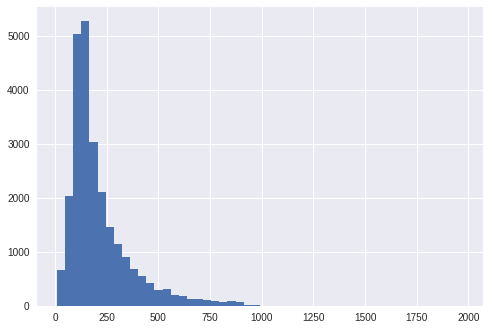

In [10]:
lengths=[len(s) for s in sequences]

plt.hist(lengths,bins=50)
plt.show()

### Split Data

In [11]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
data.shape

(25000, 500)

In [12]:
labels=to_categorical(np.asarray(labels))
labels.shape

(25000, 2)

In [0]:
labels=np.asarray(labels)

In [14]:
indices=np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices]

num_validation_samples=int(data.shape[0]*validation_split)
num_validation_samples

2500

In [0]:
x_train=data[num_validation_samples:]
y_train=labels[num_validation_samples:]

x_val=data[:num_validation_samples]
y_val=labels[:num_validation_samples]

In [16]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((22500, 500), (22500, 2), (2500, 500), (2500, 2))

### Prepare Embedding Matrix

In [17]:
num_words=min(max_num_words,len(word_index))+1
num_words

5001

In [18]:
embedding_matrix=np.zeros((num_words,embedding_dim))
embedding_matrix.shape

(5001, 100)

In [0]:
for word, i in word_index.items():
    if i > max_num_words :
        print
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(5001, 100)

## Train Model

In [21]:
embedding_layer=Embedding(num_words,embedding_dim,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_sequence_length,
                          trainable=False)# this is important
embedding_layer.input_dim

5001

In [0]:
# without embedding matrix

embedding_layer=Embedding(num_words,embedding_dim,input_length=max_sequence_length)

### Model 

In [31]:
sequence_input=Input(shape=(max_sequence_length,),dtype="int32")
embedded_sequence=embedding_layer(sequence_input)
x= Bidirectional(LSTM(64, return_sequences=True))(embedded_sequence)
x= Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
preds = Dense(2, activation="softmax")(x)
model=Model(sequence_input,preds)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          500100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 128)          84992     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 585,350
Trainable params: 85,250
Non-trainable params: 500,100
_________________________________________________________________

### Fit Model

In [32]:
import math
from keras.optimizers import rmsprop, adam


def LRDropping(epoch):
  initial_lrate=0.001
  drop=0.8
  epochs_drop=3.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

LRDrop = LearningRateScheduler(LRDropping)

model.compile(loss="categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

model.fit(x_train,y_train,
         batch_size=128,
         epochs=40,
         validation_data=[x_val,y_val],
         callbacks=[LRDrop])

Train on 22500 samples, validate on 2500 samples
Epoch 1/40
22500/22500 [==============================] - 28s 1ms/step - loss: 0.5574 - acc: 0.7062 - val_loss: 0.4603 - val_acc: 0.8112
Epoch 2/40
22500/22500 [==============================] - 26s 1ms/step - loss: 0.4078 - acc: 0.8167 - val_loss: 0.4293 - val_acc: 0.7988
Epoch 3/40
22500/22500 [==============================] - 27s 1ms/step - loss: 0.3475 - acc: 0.8500 - val_loss: 0.3658 - val_acc: 0.8480
Epoch 4/40
22500/22500 [==============================] - 26s 1ms/step - loss: 0.3242 - acc: 0.8610 - val_loss: 0.3529 - val_acc: 0.8500
Epoch 5/40
22500/22500 [==============================] - 26s 1ms/step - loss: 0.3031 - acc: 0.8709 - val_loss: 0.3351 - val_acc: 0.8528
Epoch 6/40
22500/22500 [==============================] - 27s 1ms/step - loss: 0.2798 - acc: 0.8838 - val_loss: 0.3245 - val_acc: 0.8588
Epoch 7/40
22500/22500 [==============================] - 27s 1ms/step - loss: 0.2685 - acc: 0.8874 - val_loss: 0.3167 - val_acc: